# Ads CTR Forecasting
Bu projede Reklamların zaman içerisindeki gösterim ve tıklama sayıları analiz edilerek sonraki bir aylık tıklama oranı değerleri tahmin edilecektir.
<br>Projede kullanılan veriler
<a href="https://thecleverprogrammer.com/2023/10/23/ads-ctr-forecasting-using-python/" target="_blank">
bu sayfada</a> temin edilmiştir.
<br>
<img src="https://labs.yolcu360.com/wp-content/uploads/2019/05/ctr.jpg" width="500px">

In [19]:
import pandas as pd
from datetime import date, timedelta
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA # Auto Regressive Integration Moving Average
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Verilerin Alınması

In [2]:
df=pd.read_csv("ctr.csv")

In [3]:
df.head()

,Date,Clicks,Impressions
0,2022-10-19,2851,58598
1,2022-10-20,2707,57628
2,2022-10-21,2246,50135
3,2022-10-22,1686,40608
4,2022-10-23,1808,41999


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         365 non-null    object
 1   Clicks       365 non-null    int64 
 2   Impressions  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


### Verilerin Zaman Serisine Uygunluk Analizi

In [5]:
import plotly.express as px

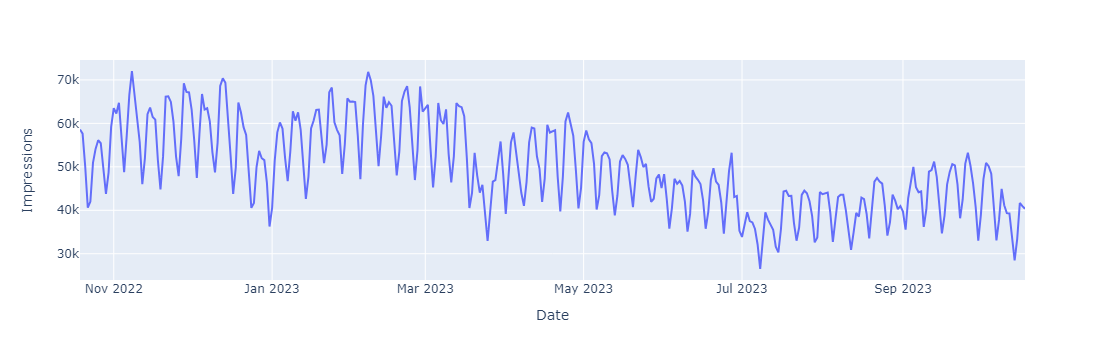

In [8]:
px.line(df, x="Date", y="Impressions")

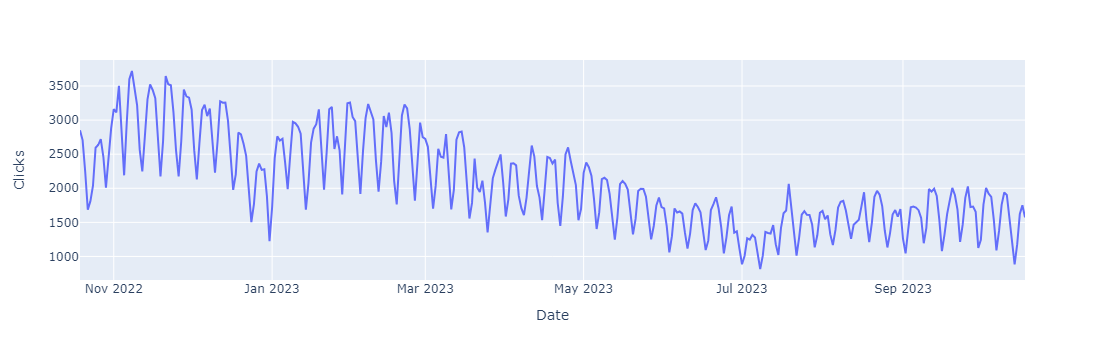

In [7]:
px.line(df, x="Date", y="Clicks")

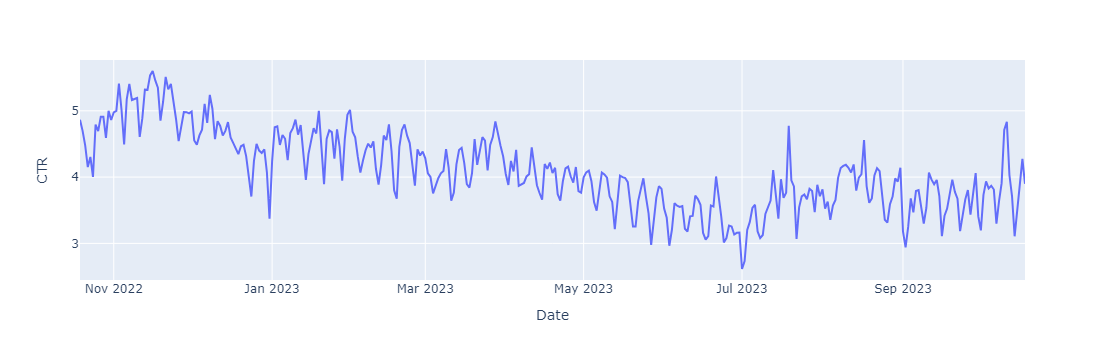

In [9]:
# CTR (Click-Through Rate) değerlerini hesaplayalım
df['CTR'] = (df['Clicks'] / df['Impressions']) * 100
px.line(df, x="Date", y="CTR")

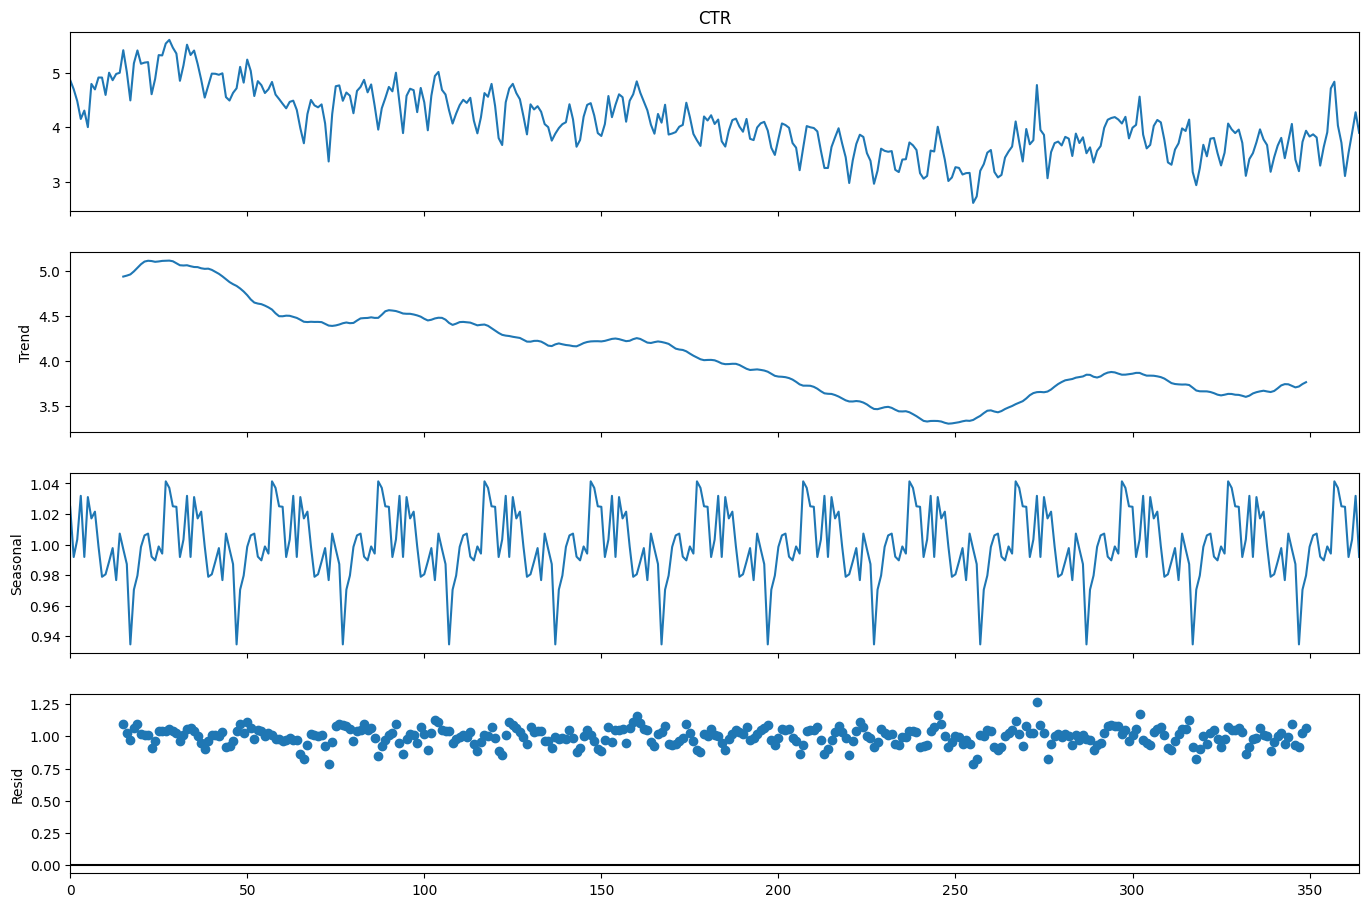

In [10]:
result = seasonal_decompose(df["CTR"], model="multiplicative", period=30)
fig = result.plot()
fig.set_size_inches(15,10)

Üzerinde çalıştığımız bu seride elde edilen grafikler aşağıdaki gibidir:
* Trend: Aşağı doğru bir trend eğilimi görülmektedir.
* Seasonal: Aylık sezonlara bakıldığında benzer tekrarın olması bu serinin analiz için uygun olduğu anlamına gelir.
* Resid: Trend ve Seasonal veri çıkarıldığında geriye çok fazla gürültünün kalmaması yine analize uygun veri seti olduğunu gösterir.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

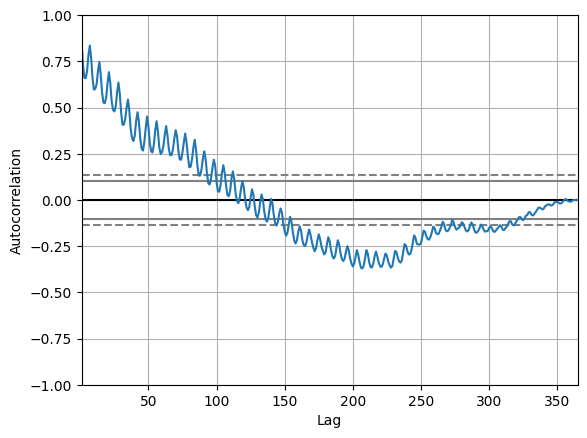

In [12]:
pd.plotting.autocorrelation_plot(df["CTR"])

Yukarıdaki grafikte çizginin düz bir çizgi olmaması zaman içindeki değişimlerin anlamlı olduğunu göstermektedir. Dolayısıyla 
verilerdeki günlük değişimlerin birbiri ardında anlamlı bir farklılık göstermektedir.

In [13]:
model = sm.tsa.statespace.SARIMAX(df["CTR"])
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    CTR   No. Observations:                  365
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -92.812
Date:                Mon, 08 Apr 2024   AIC                            189.623
Time:                        17:14:18   BIC                            197.423
Sample:                             0   HQIC                           192.723
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9965      0.004    270.026      0.000       0.989       1.004
sigma2         0.0960      0.007     13.890      0.000       0.082       0.110
Ljung-Box (L1) (Q):                   0.93   Jarque-

In [16]:
predictions = results.predict(len(df), len(df)+30)
predictions

365    3.884675
366    3.871105
367    3.857582
368    3.844106
369    3.830678
370    3.817297
371    3.803962
372    3.790674
373    3.777432
374    3.764236
375    3.751087
376    3.737983
377    3.724926
378    3.711914
379    3.698947
380    3.686026
381    3.673149
382    3.660318
383    3.647532
384    3.634790
385    3.622093
386    3.609440
387    3.596831
388    3.584267
389    3.571746
390    3.559269
391    3.546836
392    3.534446
393    3.522099
394    3.509795
395    3.497535
Name: predicted_mean, dtype: float64

<Axes: >

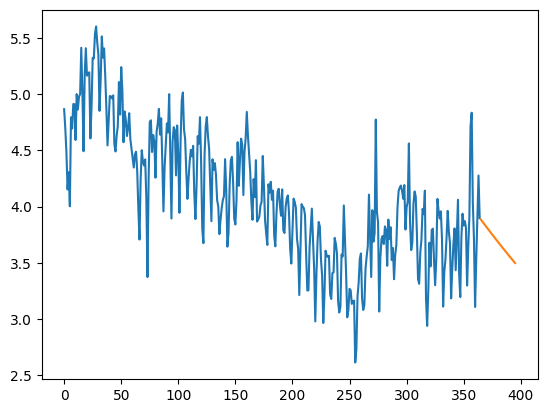

In [17]:
df["CTR"].plot()
predictions.plot()

Yukarıdaki result.summary sonucuna ve grafikteki değerlere bakılınca, hata terimlerinin otokorelasyon olmadığını ve normal dağılıma uymadığını göstermektedir. Bu yüzden ARIMA parametrelerini değiştirip yeniden eğitelim.

In [20]:
import statsmodels.api as sm
p, d, q = 2, 1, 2
model = sm.tsa.statespace.SARIMAX(df['CTR'], order=(p, d, q), seasonal_order=(p, d, q, 12))
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 -38.062
Date:                            Mon, 08 Apr 2024   AIC                             94.124
Time:                                    17:17:34   BIC                            128.897
Sample:                                         0   HQIC                           107.962
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1082      0.077     14.399      0.000       0.957       1.259
ar.L2         -0.7107      0.051   

In [21]:
predictions = model.predict(len(df), len(df)+30)
print(predictions)

365    3.762942
366    3.709816
367    3.641286
368    3.552216
369    3.578058
370    3.678004
371    3.751829
372    3.790684
373    3.614075
374    3.595211
375    3.635912
376    3.712336
377    3.662650
378    3.754056
379    3.704522
380    3.742023
381    3.762615
382    3.677194
383    3.653583
384    3.632060
385    3.631584
386    3.673433
387    3.735984
388    3.676727
389    3.594302
390    3.716936
391    3.733420
392    3.769559
393    3.745846
394    3.628194
395    3.629778
Name: predicted_mean, dtype: float64


<Axes: >

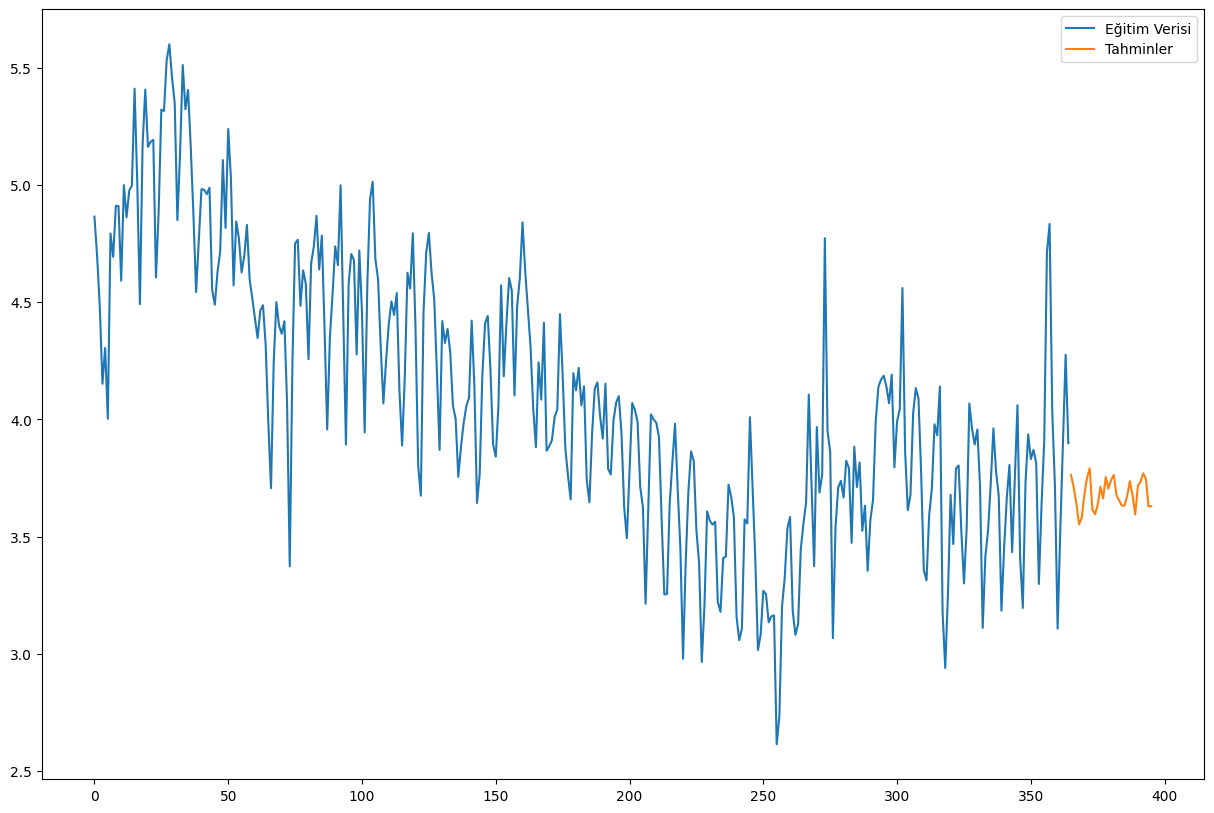

In [23]:
df["CTR"].plot(legend=True, label="Eğitim Verisi", figsize=(15, 10))
predictions.plot(legend=True, label="Tahminler")

In [24]:
forecast_data = df.rename(columns={"Date":"ds", "CTR":"y"})

17:53:28 - cmdstanpy - INFO - Chain [1] start processing
17:53:28 - cmdstanpy - INFO - Chain [1] done processing


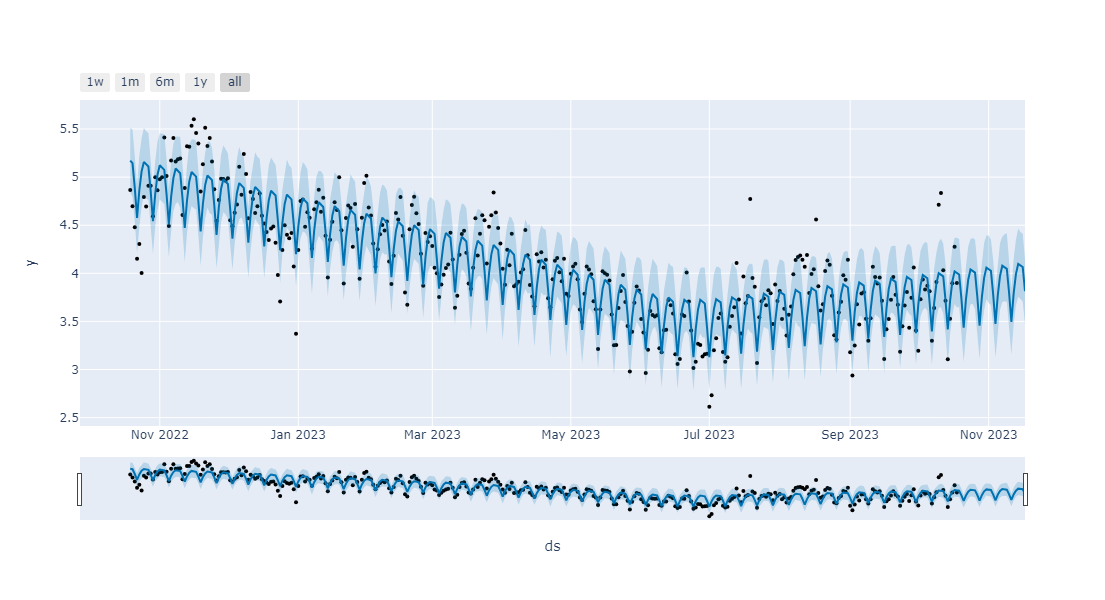

In [26]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
model=Prophet()
model.fit(forecast_data)
forecasts = model.make_future_dataframe(periods=30)
predictions = model.predict(forecasts)
plot_plotly(model, predictions)

### Sonuç:
Bu projede Reklamların zaman içerisindeki gösterim ve tıklama sayıları analiz edilerek sonraki bir aylık tıklama oranı değerleri tahmin edilmiştir. Üzerinde çalışılan zaman serisi değerleri baz alınarak eğitilen modelin ürettiği 30 günlük tahmin değerler, gerçek değerlere yakın olmakla beraber düz bir ilerleme göstermiştir. 